# Cultural project

This project is dedicated to the application of machine learning algorithms and tools to analysis of anthropological and sociological datasets. We would experiment with both supervised and unsupervised learning algorithms, such as clustering, decision trees, association rules, and artificial neural networks and many others. The goal is to extract meaningful patterns from such datasets as World Value Survey.

Before we apply any algorithms to the WVS data, we need to make sure that the data has high quality. We need to detect and correct corrupt, invalid, or inaccurate records from the data set and changing the range of data value for easiler processing later.

# 1. Data cleaning

data_0.csv: data with headers(the title of questions)  
data_1.csv: data with several most representative country in each cluster, and missing values removed/imputed & columns combined  
data_2.csv: data with religion code transformed and ready to use

----------------------------------------------------
data_3.csv: normalized data & convert categorical into numeric for clustering  
data_4.csv: data with labels from clustering

### 1.1 Load data and questions

In [1]:
raw_data = "../data_set/cultural_data/clean_data/clean_data.csv"
WVS_questions = "../data_set/cultural_data/clean_data/WVS_topics_questions2.csv"
country_name = "../data_set/cultural_data/clean_data/country_code.csv"
religion_name = "../data_set/cultural_data/clean_data/religion_code.csv"

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv(raw_data,header=None)
questions = pd.read_csv(WVS_questions,header=None)
country = pd.read_csv(country_name,header=None)
religion = pd.read_csv(religion_name,header=None)

Add headers to dataframes of questions, country, religion and add the title of questions as headers to data.

In [3]:
questions.columns = ["title","min","max","type","norm_type","text"]
data.columns = questions["title"]
country.columns = ["name"]
religion.columns = ["data","name","type"]

data.to_csv("../data_set/cultural_data/clean_data/data_0.csv", index = False)

### 1.2 Country preprocessing & selection

Process country name

In [4]:
# Processing country names
new = country['name'].str.split("'", n = 1, expand = True)
new[1] = new[1].str.replace("'","")
new[0] = new[0].astype(int)
country['index'], country['name'] = new[0],new[1]
country.to_csv("../data_set/cultural_data/clean_data/country.csv", index = False)

Select all the representative countries of each cultural group

In [5]:
rep_country_name = "../data_set/cultural_data/clean_data/representative_countries.csv"
rep_country = pd.read_csv(rep_country_name,header=None)
rep_country.columns = ["country","culture_group"]

index_df = rep_country['country'].str.split(" ", n = 1, expand = True)
rep_country["index"],rep_country["country"] = index_df[0],index_df[1]

data = data[data["V2"].isin(rep_country["index"])]
print(len(data))

72751


### 1.3 Work with missing values

Remove columns that are meaningless or not applicable

In [6]:
columns_name = "../data_set/cultural_data/clean_data/columns.csv"
columns_df = pd.read_csv(columns_name,header=None)
columns_df.columns = ["index","question","operation_type","question_type"]

dropped_col = columns_df[columns_df["operation_type"]==0]["index"].to_list()

data = data.drop(columns=dropped_col)
print(len(data.columns))

224


impute missing values with country means and output countries with all empty values to rm_country2.csv  
(Because if we impute by country means, we would end up with fractions when we convert categorical values to numeric, therefore we choose to impute by country mode)

In [7]:
data[data<0] = np.nan
gb = data.groupby("V2")
dfs = [[x,gb.get_group(x)] for x in gb.groups]
new_dfs = []
rm_country = pd.DataFrame(columns=["country_code","country_name","len_empty","empty_column"])

# For each country, if any column has all NA value, append the column & country name to rm_country, else impute the NA value with country mean
for ele in dfs:
    cur_df = ele[1]
    empty_column = []   
    
    for column in cur_df.columns:
        if cur_df[column].isnull().sum() == len(cur_df[column]):
            empty_column.append(column)
        else:
            cur_df[column].fillna(cur_df[column].mode()[0], inplace = True)
#             cur_df[column].fillna(int(cur_df[column].mean()), inplace = True)
    
    c_name = country[country['index'] == ele[0]]['name'].iloc[0]
    rm_country.loc[len(rm_country)] = [ele[0],c_name,len(empty_column),empty_column]
    new_dfs.append(cur_df)

data = pd.concat(new_dfs)
data.to_csv("../data_set/cultural_data/clean_data/data_1.csv", index = False)
print(data.isnull().sum())
rm_country.to_csv("../data_set/cultural_data/clean_data/rm_country2.csv", index = False)


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


title
V2          0
V4          0
V5          0
V6          0
V7          0
        ...  
V246     6604
V248        0
V249        0
V250     1000
V253    14364
Length: 224, dtype: int64


Replace missing value with 0

In [8]:
add_col = columns_df[columns_df["operation_type"]==2]["index"].to_list()
print(add_col)
for col in add_col:
    if data[col].min == 0:
        data[col] = data[col] + 1
    data.loc[data[col].isnull(), col] = 0
    print(col,data[col].isnull().sum())

['V36', 'V37', 'V38', 'V40', 'V41', 'V42', 'V43', 'V95', 'V178', 'V185', 'V203A', 'V204', 'V206', 'V207A', 'V245', 'V246', 'V253']
V36 0
V37 0
V38 0
V40 0
V41 0
V42 0
V43 0
V95 0
V178 0
V185 0
V203A 0
V204 0
V206 0
V207A 0
V245 0
V246 0
V253 0


Combine columns with missing values

In [9]:
com_cols = [columns_df[columns_df["operation_type"] == x]["index"].to_list() for x in range(3,18)]
print(com_cols)

for com_col in com_cols:
    com_col = list(set(com_col)-(set(com_col)-set(data.columns)))
    
    # Add missing value for each column
    for col in com_col:
        if data[col].min == 0:
            data[col] = data[col] + 1
        data.loc[data[col].isnull(), col] = 0
    
    # Combine different columns with their sum
    data[com_col[0]] = data[com_col].sum(axis=1)
    com_col.remove(com_col[0])
    data = data.drop(columns=com_col)

# output counts for missing value in all columns
data.isnull().sum().to_csv("../data_set/cultural_data/clean_data/empty_columns.csv", index = True)


[['V24', 'V56'], ['V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35'], ['V39', 'V46'], ['V45', 'V50', 'V54'], ['V51', 'V53'], ['V74', 'V74B'], ['V82', 'V83'], ['V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94'], ['V109', 'V129', 'V135'], ['V110', 'V111', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167'], ['V157', 'V160', 'V168'], ['V226', 'V227', 'V228'], ['V229', 'V235'], ['V198', 'V199', 'V201'], ['V243', 'V244']]


Deal with columns which have special meanings for NA

In [10]:
# Column V58: replace Hong Kong NA with 0.6
data["V58"].fillna(0.6, inplace = True)

# Column V144, V146, V147, V148, V149, V152, V154: replace Egypt NA with muslim/often/yes
data["V144"].fillna(5, inplace = True)   # Muslim 5
data["V146"].fillna(1, inplace = True)   # often 1

col_ls = ["V147","V148","V149","V152","V154"]
for col in col_ls:
    data[col].fillna(1, inplace = True)   # yes 1

# Column V203 homosexuality: replace Egypt NA with never
data["V203"].fillna(1, inplace = True)

# Column V250 live with parents: replace Hong Kong NA with yes
data["V250"].fillna(1, inplace = True)

print(data.isnull().sum().sum())
data.to_csv("../data_set/cultural_data/clean_data/data_1.csv", index = False)


0


### 2.4 Reduce column cardinality (religion)

Clean the religion dataset, output the cleaned religion and convert the religion column in data to categorical codes

In [11]:
cleaned_religion = religion[4:].reset_index()

religion_df = pd.DataFrame(columns=["index","name","type_n"])
religion_data = cleaned_religion["data"].str.split("'", n = 1, expand = True)
religion_data[1] = religion_data[1].str.replace("'","")
religion_data[0] = religion_data[0].astype(int)

religion_map = {'Non-religious':0,'Spiritualism':1,'General':2,'Judaism':3,'Christianity':4,'Islam':5,
                'Syncretism':6,'Confucianism':7,'Taoism':8,'Buddhism':9,'Ethnic':10,
                'Jainism':11,'Paganism':12,'Zoroastrianism':13,np.nan:-1}
religion_df["index"],religion_df["name"] = religion_data[0],religion_data[1]
religion_df["type_n"] = [religion_map[x] for x in cleaned_religion["type"]]

new = pd.DataFrame({"index":[-5,-4,-2,-1],"name":["Na"]*4,"type_n":[-1]*4})
religion_df = pd.concat([religion_df,new]).reset_index().drop(columns=["level_0"])
print(religion_df)
religion_df.to_csv("../data_set/cultural_data/clean_data/cleaned_religion.csv", index = False)

data["V144"] = [religion_df[religion_df["index"]==x]["type_n"].iloc[0] for x in data["V144"]]

# print(data["V144"])
data.to_csv("../data_set/cultural_data/clean_data/data_2.csv", index = False)


      index                               name  type_n
0         0                               None       0
1         1                          Aglipayan       4
2         2                           Al-Hadis       5
3         3                           Alliance       4
4         4  Ancestral worshipping / Tradition      10
..      ...                                ...     ...
97   710002   ZA: African Traditional Religion      10
98       -5                                 Na      -1
99       -4                                 Na      -1
100      -2                                 Na      -1
101      -1                                 Na      -1

[102 rows x 3 columns]


### 2.5 Convert categorical into numeric & normalization

Process country dataframe and output the cleaned country dataset and the respondent per country

In [12]:
country_data = data.groupby(["V2"]).count().sort_values(["V4"],ascending=False)

country_df = pd.DataFrame(columns=["name","index","respondents"])
country_df["index"] = country_data.index
country_df["respondents"] = np.array(country_data['V4'])

country_df["name"] = [country[country['index'] == x]['name'].iloc[0] for x in country_df["index"]]

country_df.to_csv("../data_set/cultural_data/clean_data/country_respondent.csv", index = False)


Normalize the dataset

In [13]:
# Normalize the data
columns = data.columns.to_list()
columns.remove("V2")

for column in columns:
    minimum = int(data[column].min())
    maximum = int(data[column].max())
    norm_type = questions[questions["title"]==column].norm_type.iloc[0]
    
    if norm_type == 2:
        for i in range(minimum,maximum+1):
            index = data.columns.get_loc(column) + i
            name = column+"_"+str(i)
            col = [0]*len(data[column])
            for j in range(len(data[column])):
                col[j] = 1 if data[column].iloc[j] == i else 0
            data.insert(index,name,col)
        data = data.drop(columns=[column])

    elif norm_type == 1:
        data[column] = (data[column]-minimum)/(maximum-minimum)
        
    elif norm_type == 3:
        data[column] = 1-(data[column]-minimum)/(maximum-minimum)
        
data.to_csv("../data_set/cultural_data/clean_data/data_3.csv", index = False)

# 2. Clustering & evaluation

After cleaning up data and normilizing data, we can begin to use kmeans model implemented in sklearn to cluster data.

We compute SSE for each cluster size, plot it on the graph and try to find an elbow point that indicated the best k value.

3
4
5
6
7
8
9
10
11


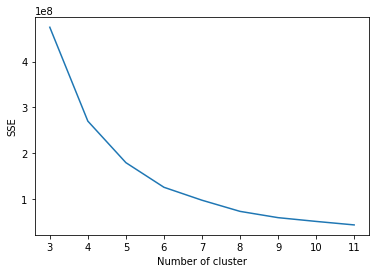

In [14]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

sse = {}
for i in range(3,12):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    sse[i] = kmeans.inertia_ 
    print(i)

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()


We choose k = 7 to perform kmeans clustering and output cluster result for each country to result.csv

In [15]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(data)
labels = kmeans.labels_

data["label"] = labels
result = data.groupby(["label","V2"]).agg({'V4': ["count"]}).reset_index()
result.rename(columns={"label": "cluster", "V2": "country_label","V4":"number_of_respondents"}, inplace=True)

data.to_csv("../data_set/cultural_data/clean_data/data_4.csv", index = False)
result.to_csv("../data_set/cultural_data/clean_data/result.csv", index = False)
# print(result)

clean clustering result and output clusters for each country to country_result.csv

In [16]:
print(len(labels),len(data["V4"]))
data["label"] = labels
result = data.groupby(["label","V2"]).agg({'V4': ["count"]}).reset_index()
result.rename(columns={"label": "cluster", "V2": "country_label","V4":"number_of_respondents"}, inplace=True)

country_result = pd.concat([data["V2"],data["label"]], axis=1, keys=['country', 'cluster'])
country_result = country_result.groupby(["country","cluster"]).agg({'country': ["count"]}).reset_index()

country_result.to_csv("../data_set/cultural_data/clean_data/country_result.csv", index = False)
country_result = pd.read_csv("../data_set/cultural_data/clean_data/country_result.csv", skiprows=[1])
country_result = country_result.drop(columns=["country.1"])

country_result["country"] = [country[country['index'] == x]['name'].iloc[0] for x in country_result["country"]]
print(country_result.values.tolist())

result.to_csv("../data_set/cultural_data/clean_data/result.csv", index = False)
country_result.to_csv("../data_set/cultural_data/clean_data/country_result.csv", index = False)
# print(result)

72751 72751
[['Algeria', 4], ['Argentina', 4], ['Australia', 4], ['Brazil', 4], ['Chile', 0], ['China', 0], ['Colombia', 0], ['Ecuador', 0], ['Estonia', 0], ['Georgia', 0], ['Germany', 0], ['Hong Kong', 2], ['India', 2], ['Iraq', 2], ['Japan', 2], ['Kazakhstan', 2], ['Jordan', 2], ['South Korea', 2], ['Kyrgyzstan', 2], ['Lebanon', 2], ['Libya', 2], ['Malaysia', 2], ['Mexico', 3], ['Netherlands', 3], ['Nigeria', 3], ['Pakistan', 6], ['Peru', 6], ['Philippines', 6], ['Poland', 6], ['Romania', 6], ['Russia', 6], ['Rwanda', 6], ['Singapore', 1], ['South Africa', 1], ['Zimbabwe', 1], ['Spain', 1], ['Sweden', 1], ['Thailand', 1], ['Tunisia', 5], ['Turkey', 5], ['Ukraine', 5], ['Egypt', 5], ['United States', 5], ['Uruguay', 5], ['Yemen', 5]]


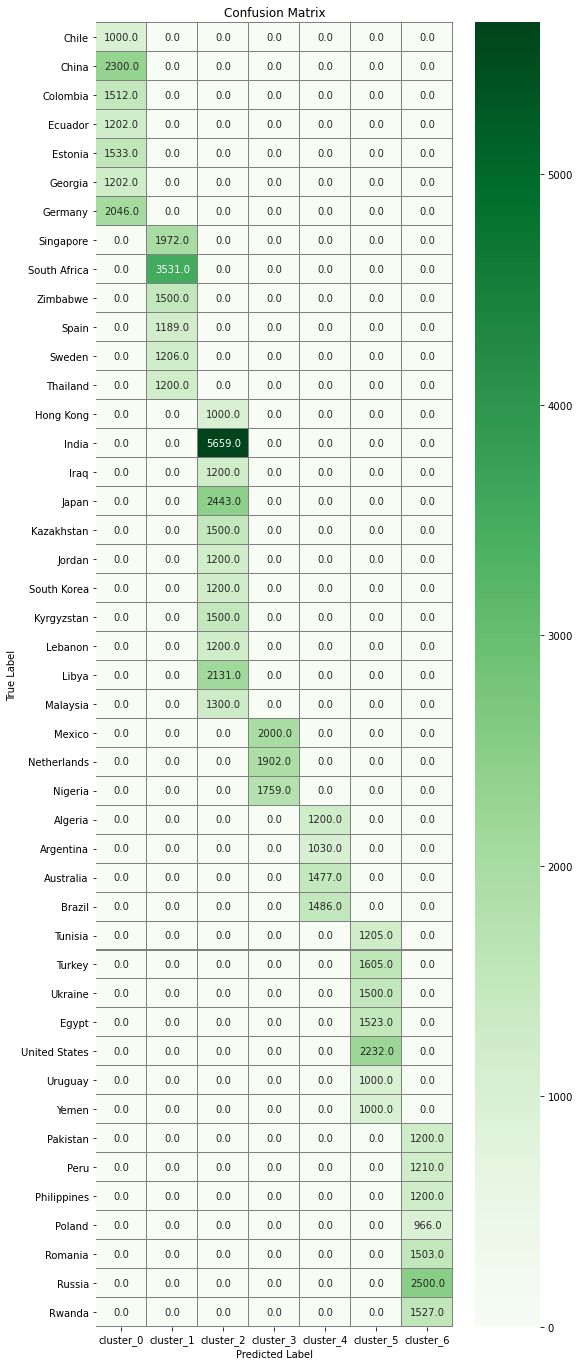

In [18]:
import seaborn as sns

conf_index = [country[country["index"] == x]["name"].iloc[0] for x in result["country_label"]]
conf_mtr = pd.DataFrame(columns=["cluster_"+str(x) for x in range(7)],
                       index=conf_index)

for i in range(conf_mtr.shape[1]):
    col = conf_mtr.columns[i]
    country_label = list(result[result["cluster"]==i]["country_label"])
    country_name_label = [country[country["index"] == x]["name"].iloc[0] for x in country_label]

    respondents = list(result[result["cluster"]==i]["number_of_respondents"]["count"])
    for j in range(len(country_label)):
        conf_mtr[col].loc[country_name_label[j]] = respondents[j]

conf_mtr.fillna(0,inplace=True)
conf_mtr.to_csv("../data_set/cultural_data/clean_data/conf_mtr.csv", index = False)

f,ax = plt.subplots(figsize=(8, 24))
sns.heatmap(conf_mtr, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

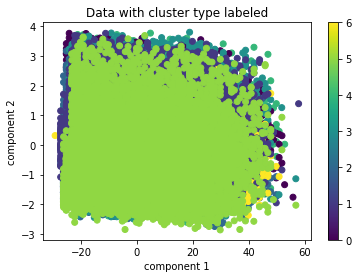

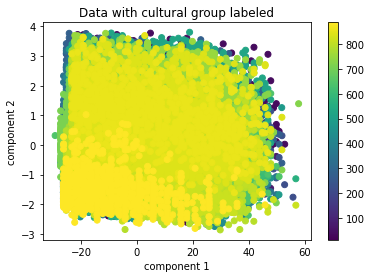

In [26]:
from sklearn.decomposition import PCA
%matplotlib inline

pca = PCA(n_components=2)
projected = pca.fit_transform(data.iloc[:,1:-2])

plt.scatter(projected[:, 0], projected[:, 1], c=data.label)
plt.title("Data with cluster type labeled")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()

plt.scatter(projected[:, 0], projected[:, 1], c=data.V2)
plt.title("Data with cultural group labeled")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()

In [24]:
# 3d data visualization with cluster type labeled by color
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
projected = pca.fit_transform(data.iloc[:,1:-2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(projected[:, 0], projected[:, 1], projected[:, 2], c=data.label, marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()
